In [1]:
import openai
from openai import OpenAI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import dump
from joblib import load
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
df_LCI = pd.read_csv('C:/Users/89751/OneDrive/Desktop/Text-embedding classification/LCI_train11.csv')
df_LCI

,Unnamed: 0,Paper_title,Table_title,is LCI inventory table?
0,2,1,Table 2 Data summary related to additive manuf...,No
1,3,1,Table 3 Main resource consumption and emission...,Yes
2,4,1,Table 4 Normalization results of three manufac...,No
3,6,3,Table 1 Inputs and outputs associated with the...,Yes
4,7,3,Table 2 Fertilizers used for growing 1 hectare...,No
...,...,...,...,...
151,225,47,Table 6 Scenario analysis of COG route with MP...,No
152,226,48,Table 1 Inventory data for the production and ...,Yes
153,230,49,Table 2 Data inventory for LDG-ethanol process.,Yes
154,231,49,Table 3 Data inventory for Corn-ethanol and Co...,Yes


In [31]:
def generate_embeddings(text):
    # set credentials
    client = OpenAI(
     api_key=os.environ.get("OPENAI_API_KEY"),)
    
    # make api call
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    
    # return text embedding
    return response.data

In [32]:
# generate embeddings
text_embeddings = generate_embeddings(df_LCI['Table_title'])
# extract embeddings
text_embedding_list = [text_embeddings[i].embedding for i in range(len(text_embeddings))]

In [33]:
# define df column names
column_names = ["embedding_" + str(i) for i in range(len(text_embedding_list[0]))]

# store text embeddings in dataframe
df_train = pd.DataFrame(text_embedding_list, columns=column_names)

# create target variable
df_train['is_LCI'] = df_LCI['is LCI inventory table?']=="Yes"
df_train.to_csv('C:/Users/89751/OneDrive/Desktop/embeddings_train.csv', index=False)
df_train.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,is_LCI
0,-0.020123,0.057902,0.055091,-0.022478,0.005656,-0.016658,0.011849,-0.015117,-0.021738,-0.011072,...,0.011707,-0.020591,-0.036546,0.001382,0.056571,-0.035782,-0.022367,0.010456,0.024488,False
1,0.015224,0.080593,0.075669,-0.015590,0.047464,-0.003169,0.002727,-0.005650,0.049585,-0.013006,...,0.020185,-0.010696,-0.031716,-0.002762,0.026986,-0.008368,0.006393,0.006338,0.027645,True
2,-0.002157,0.039381,0.043359,-0.041574,0.021909,-0.022776,0.013531,-0.002077,-0.000497,-0.040605,...,0.023031,-0.010132,-0.043538,0.009577,0.015010,0.003234,-0.017357,-0.022381,0.021080,False
3,-0.022286,0.058410,0.028477,-0.009710,-0.005495,-0.041305,0.031743,0.032870,0.021005,0.010567,...,0.027231,-0.017504,-0.016694,-0.033481,0.035055,-0.030262,0.010561,0.002458,0.026785,True
4,-0.013763,0.011658,0.063764,-0.030198,0.023364,-0.056642,-0.031786,0.025698,0.013607,0.017710,...,0.030270,0.017794,0.015556,0.006455,0.004665,-0.015183,-0.025193,-0.015111,-0.003381,False


In [34]:
# split variables by predictors and target
X = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

# apply PCA to predictors (i.e. embeddings)
pca = PCA(n_components=2).fit(X)
print(pca.explained_variance_ratio_)

[0.06716215 0.05789671]


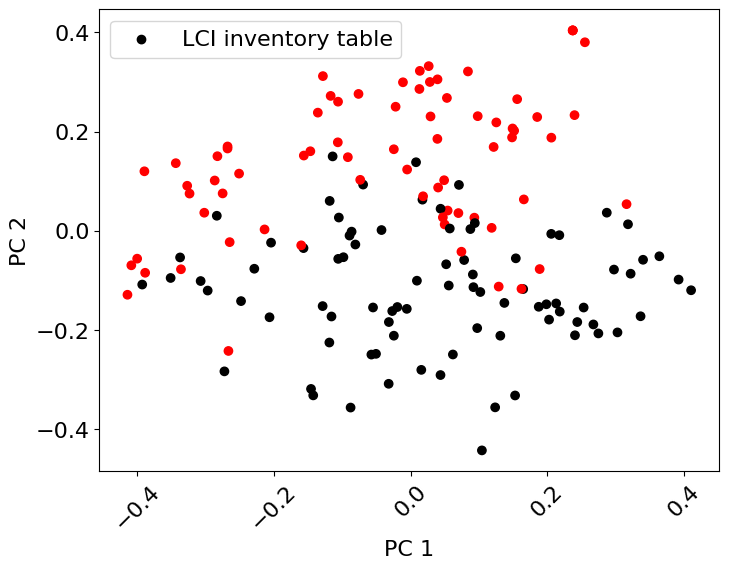

In [48]:
# plot data along PCA components
c_arr = np.array(["k"] * len(y))
c_arr[y == True] = "r"

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=c_arr)
plt.legend(["LCI inventory table"])
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

In [50]:
from matplotlib.lines import Line2D

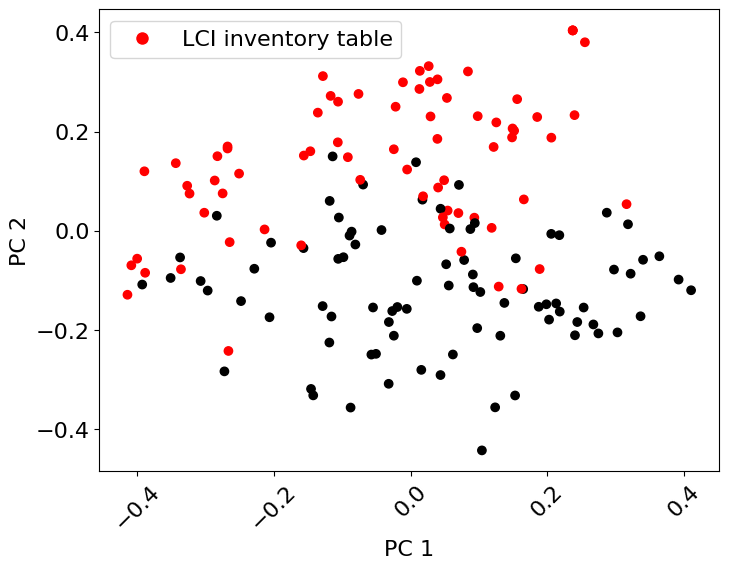

In [51]:
c_arr = np.array(["k"] * len(y))
c_arr[y == True] = "r"

# Creating the plot
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=c_arr)

# Creating a custom legend with red label
legend_elements = [Line2D([0], [0], marker='o', color='w', label='LCI inventory table',
                          markerfacecolor='r', markersize=10)]
plt.legend(handles=legend_elements)

# Axis labels and rotation
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Show the plot
plt.show()

In [36]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
# train rf model
# Adjust more parameters for better model tuning
rf = RandomForestClassifier(
    n_estimators=150,  # Increased number of trees to enhance model accuracy
    max_depth=5,        # Increased depth to capture more complex patterns, adjust as needed
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    min_samples_leaf=4,    # Minimum number of samples required to be at a leaf node
    random_state=42         # Ensures reproducibility
)

rf.fit(X_train, y_train)
rf.score(X,y) # model accuracy for training data

dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [38]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.875


In [16]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002151E0695B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002151E06B650>})

In [17]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 394}


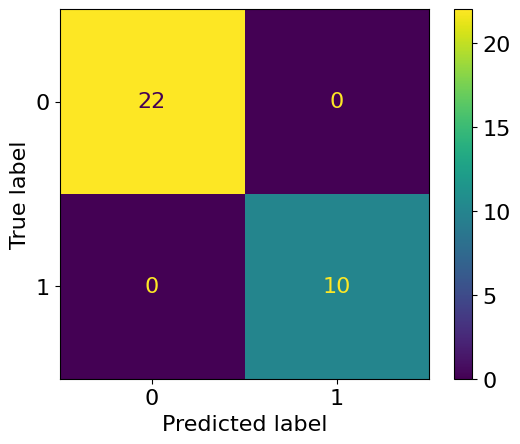

In [39]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [26]:
# print feature importance ranking
feature_importances = pd.Series(best_rf.feature_importances_, index=column_names)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print(feature_importances_sorted[:25])

embedding_1499    0.024439
embedding_1460    0.014903
embedding_460     0.014578
embedding_601     0.013937
embedding_387     0.013634
embedding_575     0.011601
embedding_370     0.011455
embedding_549     0.011343
embedding_787     0.011139
embedding_842     0.011009
embedding_656     0.010766
embedding_557     0.009342
embedding_685     0.008900
embedding_714     0.008446
embedding_628     0.007861
embedding_950     0.007294
embedding_944     0.007268
embedding_1087    0.006838
embedding_1156    0.006709
embedding_279     0.006631
embedding_1161    0.005973
embedding_1167    0.005881
embedding_547     0.005832
embedding_1399    0.005760
embedding_587     0.005725
dtype: float64


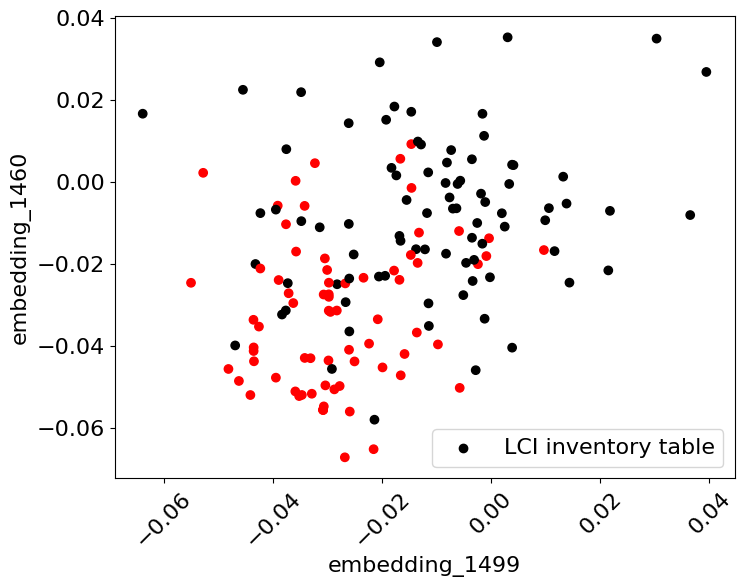

In [40]:
# plot data along top 2 most important features
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.scatter(X[feature_importances_sorted.index[0]], X[feature_importances_sorted.index[1]], c=c_arr)
plt.legend(["LCI inventory table"])
plt.xticks(rotation = 45)
plt.xlabel(feature_importances_sorted.index[0])
plt.ylabel(feature_importances_sorted.index[1])
plt.show()

In [116]:
# import testing data
df_LCI = pd.read_csv('C:/Users/89751/OneDrive/Desktop/LCI_test.csv')

# generate embeddings
text_embedding_list = generate_embeddings(df_LCI['Table_title'])
text_embedding_list = [text_embedding_list[i].embedding for i in range(len(text_embedding_list))]

# store text embeddings in dataframe
df_test = pd.DataFrame(text_embedding_list, columns=column_names)

# create target variable
df_test['is_inventory_data'] = df_LCI['Results']=="Yes"
#df_test.to_csv('resumes/embeddings_test.csv', index=False)
df_test.head()

# define predictors and target
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [117]:
# accuracy
clf.score(X_test,y_test)

0.9607843137254902

In [118]:
# auc
auc_val = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
auc_val

1.0

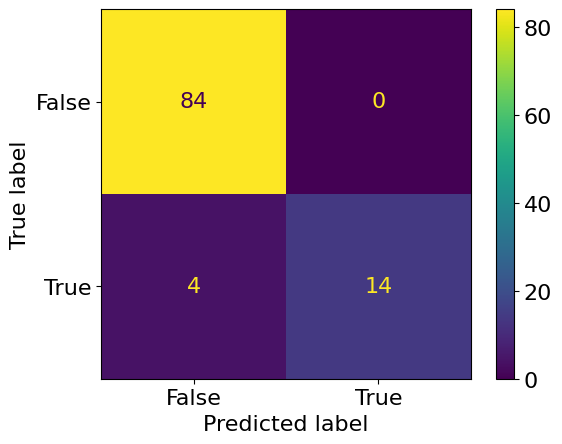

In [119]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

In [120]:
# import testing data
df_LCI = pd.read_csv('C:/Users/89751/OneDrive/Desktop/LCI_test1.csv')

# generate embeddings
text_embedding_list = generate_embeddings(df_LCI['Table_title'])
text_embedding_list = [text_embedding_list[i].embedding for i in range(len(text_embedding_list))]

In [121]:
clf_loaded = load('random_forest_model.pkl')

In [122]:
embeddings_array = np.array(text_embedding_list)

# Make predictions
predictions = clf_loaded.predict(embeddings_array)

D:\Software\Anaconda\envs\LCI-extraction\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [123]:
predictions

array([False,  True, False])